# Object-Based Augmentation

This notebook provides insights into the workflow of Object-Based Augmentation.

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))
from utils.loading import load_masked_images, load_images, load_labels
from utils.visualization import plot_image, plot_masked_image
from utils.normalize import normalize
import random
import numpy as np

IMAGES_PATH = os.getenv("IMAGES_PATH")
MASKED_IMAGES_PATH = os.getenv("MASKED_IMAGES_PATH")
LABELS_PATH = os.getenv("LABELS_PATH")

## Plot of an example image to be used for an OBA example

Plot with polygons


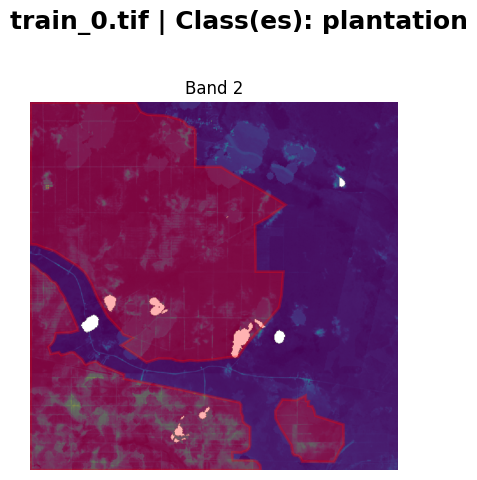

Plot without polygons


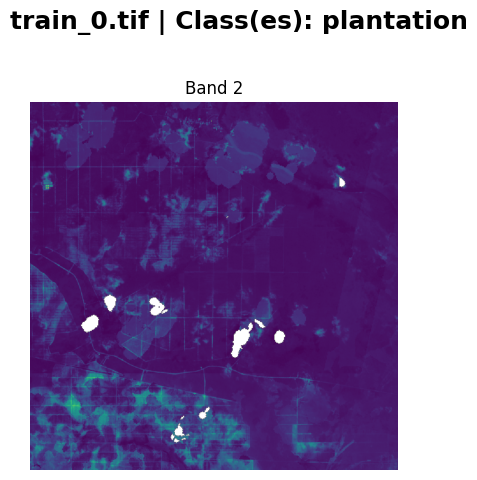

Plot with the mask for the polygons


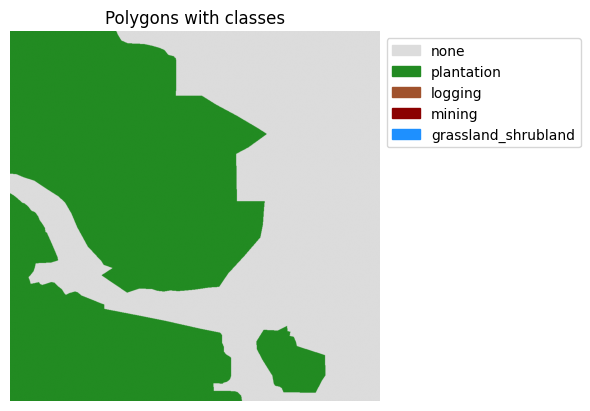

In [2]:
example_img = 'train_0.tif'
print("Plot with polygons")
plot_image(example_img, band=2, num_plots=1)
print("Plot without polygons")
plot_image(example_img, band=2, num_plots=1, polygons=False)
print("Plot with the mask for the polygons")
plot_masked_image(example_img)

## Initiate OBA Generator

In [3]:
from OBA.object_based_augmentation import Generator

generator = Generator(batch_size=10, subset=True)

Loaded 30 masked images.
Loaded 30 images.
Found 30 file names
Loaded 30 labels.
Extracted 254 objects from 12 files.


## Augmentation 

In [4]:
# choose an image
num = 0
band = 0
example_img = f'train_{num}.tif'

# extract image and mask
original_image = generator.images[example_img]["image"]
original_mask = generator.masks[example_img]["image"]

# prepare image and mask for augmentation so we don't augment the original image
image, mask = generator._prepare_image_and_mask(original_image, original_mask)

**Plot of the image before any augmentaiton has been applied.** The augmentation is categorized into geometrical and color-based transformations.

No augmentation


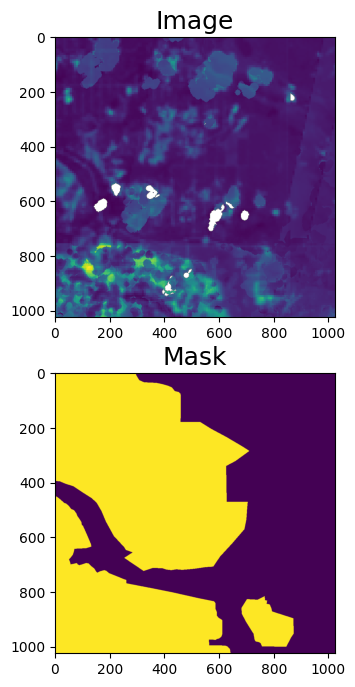

In [5]:
print("No augmentation")
generator.augm_prob=1
generator.color_augm_prob=0
generator.geometric_augm_prob=0
augmented_image, augmented_mask = generator._augment_image_mask(image, mask) # this augments the image and mask (code in augmentation.py)
generator.visualize(augmented_image[band], augmented_mask)

**Plot of the image after applying color augmentation.** The visual effect of the augmentation may not always be noticeable, as the extent of the modification depends on the following functions:

```python def add_noise(image, **kwargs):
    return image + np.random.normal(0, 0.1, image.shape).astype(image.dtype)
```

```python def scale_brightness(image, **kwargs):
    return image * np.random.uniform(0.9, 1.1)
```
As these functions introduce randomness, the degree of color augmentation can vary significantly from one instance to another.

Color augmentation


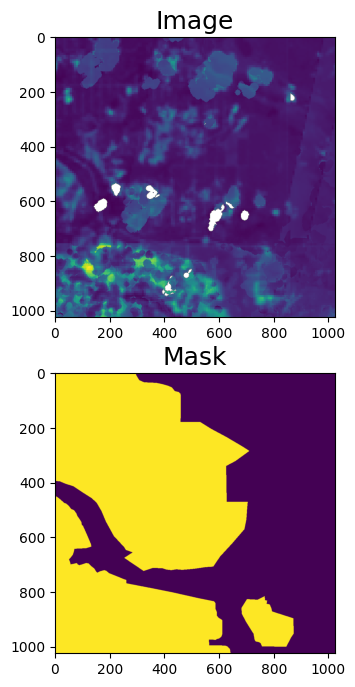

In [6]:
print("Color augmentation")
generator.color_augm_prob=1
augmented_image, augmented_mask = generator._augment_image_mask(image, mask)
generator.visualize(augmented_image[band], augmented_mask)
generator.color_augm_prob=0

**Plot of the image after applying geometrical augmentaiton.** Transformations included flipping, rotating and transposing.

Geometric augmentation


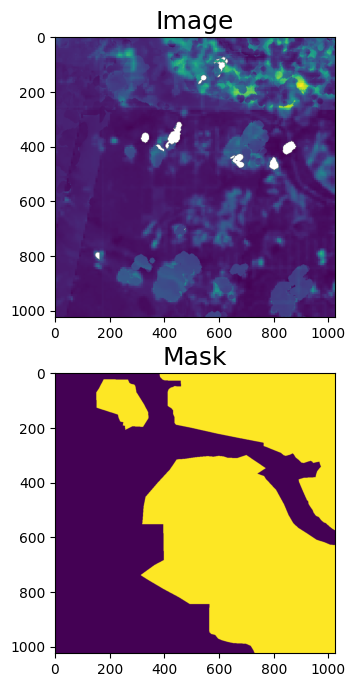

In [7]:
print("Geometric augmentation")
generator.geometric_augm_prob=1
augmented_image, augmented_mask = generator._augment_image_mask(image, mask)
generator.visualize(augmented_image[band], augmented_mask)

We can use the `_crop_target_object(object_id: int)` to crop a object from the image. This funtion crops the objects 

Generator has 254 extracted objects
Randomly chosen object id: 31


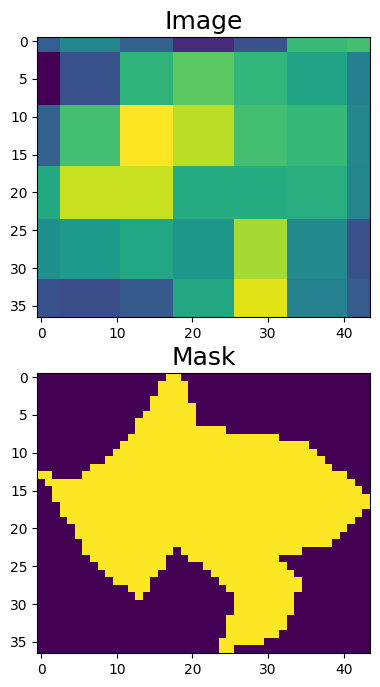

In [8]:
# extract a random object
print("Generator has",generator.num_of_extracted_objects, "extracted objects")
object_ids = [obj[-1] for obj in generator.extracted_objects]
obj_id = random.choice(object_ids)
print("Randomly chosen object id:", obj_id)

# crop and visualize the  
object_image, object_mask = generator._crop_target_object(obj_id)
generator.visualize(object_image[band], object_mask) # image: (12, 1024, 1024), mask: (1, 1024, 1024)

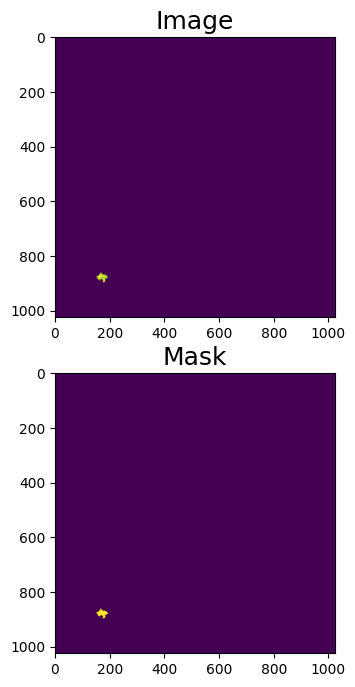

In [9]:
temp_image = np.zeros_like(image)
temp_mask = np.zeros_like(mask)
generator._tight_crop_object(temp_image, temp_mask, object_image, object_mask) # this crops the object from the image and mask
generator.visualize(temp_image[band], temp_mask) # image: (12, 1024, 1024), mask: (1, 1024, 1024)

Several parameters must be carefully selected based on the specific class requirements or user preferences.

It is important to note that `extra_backgrounds` is set to 0, as additional background images were not deemed necessary for this study. This decision was influenced by the challenges associated with sourcing suitable extra background images. However, if such images become available, they can be incorporated into the workflow by specifying the path to these images in the `.env` configuration file.

/Users/synneandreassen/Documents/MasterMaskinlæring/INF367A/Competition/INF367A-Solafune
Added 1 objects to background train_13.tif


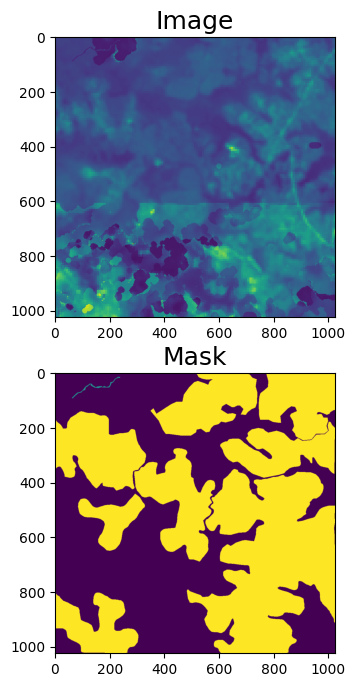

In [10]:
# to augment or not at all
generator.augm = True
# the probability of augmenting (if augm is True)
generator.augm_prob = 1
# the probability of performing geometrical augmentation
generator.geometric_augm_prob = 0.6
# the probability of performing color augmentation
generator.color_augm_prob = 0.6
# to perform object augmentation or not 
generator.object_augm = True
# the probability of performing augmentation to the object
generator.object_augm_prob = 1
# the probability of performing augmentations to the background image
generator.background_augm_prob = 0
# to apply shadows or not
generator.shadows = False
# how many extra objects to add
generator.extra_objects = 3
# to use a new background or not
generator.extra_background_prob = 0 

print(os.getcwd())
image, mask, profile = generator.generate_augmented_sample(verbose=True)
generator.visualize(image[band], mask[0]) # image: (12, 1024, 1024), mask: (1, 1024, 1024)

Here we run `create_OBA_tensor_dataset` to avoid  saving the files

In [12]:
from OBA.object_based_augmentation import create_OBA_tensor_dataset
dataset = create_OBA_tensor_dataset(
    prob_of_OBA=0.3, 
    subset=True,
    augm=True, 
    object_augm=True, 
    extra_background_prob=0, # not implemented
    background_augm_prob=0.6,
    shadows=False, # not usefull
    extra_objects=3,
    object_augm_prob=1,
    augm_prob=1,
    geometric_augm_prob=1,
    color_augm_prob=1,
    batch_size=1,
    min_area=100,
    use_SR=False,
    generator=generator,
)

Loaded 30 images.
Loaded 30 masked images.


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
folder = './data/oba_images/'
masked = './data/oba_masked_images/'
oba_images = [f for f in os.listdir(folder) if f.startswith('OBA')]
oba_masks = [f for f in os.listdir(masked) if f.startswith('OBA')]
print(f"Number of files starting with 'OBA': {len(oba_images)} in folder {folder}")
print(f"Number of files starting with 'OBA': {len(oba_masks)} in folder {masked}")

Number of files starting with 'OBA': 15 in folder ./data/oba_images/
Number of files starting with 'OBA': 14 in folder ./data/oba_masked_images/


The number of images and masks generated during creation of the dataset vary depending on the probability of OBA. This is a parameter easy to vary.